In [60]:
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import utils


def oneHotEncoding(targets):
    targetMatrix = []
    for target in digits.target:
        temp = np.zeros(10)
        temp[target] = 1.0
        targetMatrix.append(temp)
    return targetMatrix
def sigDve(x):
    return np.exp(-x)/((1+np.exp(-x)**2))
def xavier_initialization(n_inputs, n_outputs):
    stddev = np.sqrt(2 / (n_inputs + n_outputs))
    #sample randomly from a normalization with a mean of zero and a stddev defined above to create matrix
    return np.random.normal(0, stddev, (n_inputs, n_outputs))
def bias_initialization(n_units):
    # initialize biases to small random values
    stddev = 0.01
    biases = np.random.normal(0, stddev, n_units)
    return biases
class network():
    def __init__(self, layers):
        self.__layerNeurons = layers
        self.__weightMatrices = []
        self.__weightGradientMatrices = []
        self.__biasVectors = []
        self.__biasGradientVectors = []
        self.layer_values = []
        self.__layer_values_no_activation_function = []
        for layer in range(len(layers)-1):
            #Using a standard weight initialization worked better than sampling from normal distribution
            self.__weightMatrices.append(np.full((layers[layer], layers[layer + 1]), 0.01))
            self.__weightGradientMatrices.append(np.zeros((layers[layer], layers[layer + 1])))
            self.__biasVectors.append(bias_initialization(layers[layer + 1]))
            self.__biasGradientVectors.append(np.zeros(layers[layer + 1]))
            self.layer_values.append(np.zeros(layers[layer]))
            self.__layer_values_no_activation_function.append(np.zeros(layers[layer]))
        self.layer_values.append(np.zeros(layers[-1]))
        self.__layer_values_no_activation_function.append(np.zeros(layers[-1]))
        self.__cost = 0.0
    def getPreds(self):
        return self.layer_values[-1]
    def feedforward(self, inputVector):
        self.layer_values[0] = inputVector
        self.__layer_values_no_activation_function[0] = inputVector
        #For each layer apply matrix vector multiplication then add biases
        for layer in range(1, len(self.__layerNeurons)):
            self.__layer_values_no_activation_function[layer] = self.__weightMatrices[layer - 1].transpose().dot(self.layer_values[layer - 1]) + self.__biasVectors[layer - 1]
            self.layer_values[layer] = 1/(1 + np.exp(-1 * (self.__layer_values_no_activation_function[layer])))
    
    def cost(self, true):
        self.__cost += ((self.layer_values[-1] - true)**2).mean()
    
    def gradients(self, true):
        #First compute gradient for last weight matrix
        previousCostDve = []
        previousCostDves = []
        for j in range(self.__weightMatrices[-1].shape[0]):
            costDve = 0
            for k in range(self.__weightMatrices[-1].shape[1]):
                costDve += 2*(self.layer_values[-1][k] - true[k])
                self.__weightGradientMatrices[-1][j][k] += self.layer_values[-2][j] * sigDve(self.__layer_values_no_activation_function[-1][k])*2*(self.layer_values[-1][k] - true[k])
            previousCostDve.append(costDve)
        for j in range(self.__biasVectors[-1].shape[0]):
            self.__biasGradientVectors[-1][j] += sigDve(self.__layer_values_no_activation_function[-1][j])*2*(self.layer_values[-1][j] - true[j])
        previousCostDves.append(previousCostDve)
        prevousCostDve = []
        #Compute gradients for all other weight matrices
        #Gradients are summed across a batch then averaged
        for layer in range(len(self.__layerNeurons) - 3, -1, -1):
            for j in range(self.__weightMatrices[layer].shape[0]):
                costDve = 0
                for k in range(self.__weightMatrices[layer].shape[1]):
                    self.__weightGradientMatrices[layer][j][k] += self.layer_values[layer][j] * sigDve(self.__layer_values_no_activation_function[layer + 1][k])*previousCostDves[-1][k]
                previousCostDve.append(costDve)
            for j in range(self.__biasVectors[layer].shape[0]):
                self.__biasGradientVectors[layer][j] += sigDve(self.__layer_values_no_activation_function[layer + 1][j])*2*previousCostDves[-1][j]
            previousCostDves.append(previousCostDve)
    def updateWeightsBiases(self, batchsize, lr):
        #Backprop (using average of gradients from across batch)
        for i in range(0, len(self.__layerNeurons) - 1):
            self.__weightMatrices[i] = np.add(self.__weightMatrices[i], lr*(self.__weightGradientMatrices[i])/batchsize)
            self.__biasVectors[i] = np.add(self.__biasGradientVectors[i], lr*self.__biasGradientVectors[i]/batchsize)
    def resetNetwork(self):
        #Reset gradients before next batch
        self.__cost = 0;     
        for layer in range(len(self.__layerNeurons)-1):
            self.__weightGradientMatrices[layer] = np.zeros((self.__layerNeurons[layer], self.__layerNeurons[layer + 1]))
            self.__biasGradientVectors[layer] = np.zeros(self.__layerNeurons[layer + 1])
    def test(self, X_test, y_test):
        acc = 0
        test_samples = len(X_test)
        for i in range(test_samples):
            self.feedforward(X_test[i])
            acc += 1 if np.argmax(self.getPreds()) == np.argmax(y_test[i]) else 0
        return (100 * acc/test_samples)
    def predict(self, inputVector):
        self.feedforward(inputVector.flatten())
        return(np.argmax(self.getPreds()))
    def train(self, X_train, X_test, y_train, y_test, batchsize, epochs, lr):
        for epoch in range(epochs):
            for batchIndexStart in range(0, len(X_train) - batchsize, batchsize):
                self.resetNetwork()
                for sample in range(batchIndexStart, batchIndexStart + batchsize):
                    self.feedforward(X_train[sample])
                    self.cost(y_train[sample])
                    self.gradients(y_train[sample]) 
                self.updateWeightsBiases(batchsize, -lr)
        print(self.test(X_test, y_test))
                
digits = datasets.load_digits()
data = (digits.images.reshape(1797, 64))
X_train, X_test, y_train, y_test = train_test_split(
    data, oneHotEncoding(digits.target), test_size=0.9, shuffle=True)

net = network([64, 10])
net.train(X_train, X_test, y_train, y_test, 5, 100, 1e-2)

90.85290482076638


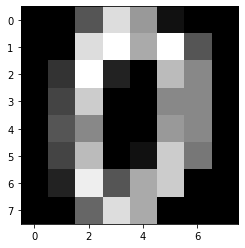

Prediction:  0
True Value:  0


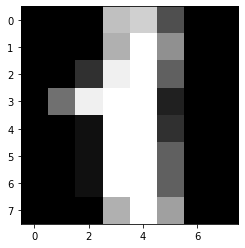

Prediction:  1
True Value:  1


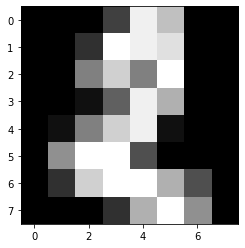

Prediction:  2
True Value:  2


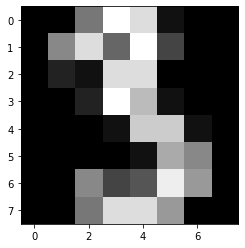

Prediction:  3
True Value:  3


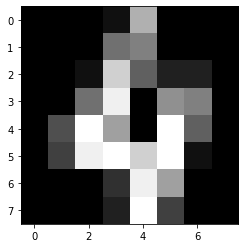

Prediction:  4
True Value:  4


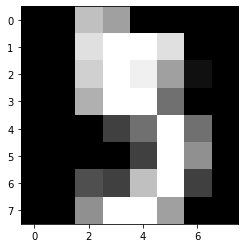

Prediction:  9
True Value:  5


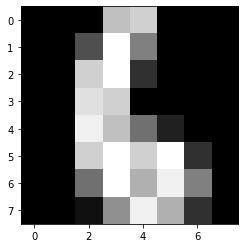

Prediction:  6
True Value:  6


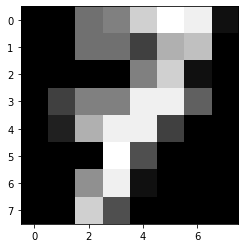

Prediction:  7
True Value:  7


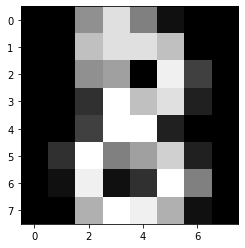

Prediction:  8
True Value:  8


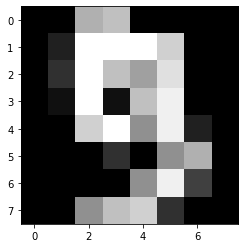

Prediction:  9
True Value:  9


In [62]:
from matplotlib import pyplot as plt
imgs = digits.images.reshape(1797, 8, 8)
for i in range(10):
    plt.figure()
    plt.imshow(imgs[i], cmap="gray")
    plt.show()
    print("Prediction: ", net.predict(imgs[i]))
    print("True Value: ", digits.target[i])
    plt.close()